In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [4]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta


# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [9]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [11]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine,reflect=True)

/var/folders/d7/tvjrqth10gb5pst1dd7n9wl40000gn/T/ipykernel_9824/2042099631.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine,reflect=True)


In [13]:
# Print all of the classes mapped to the Base
for class_name in Base.classes.keys():
   print(class_name)

measurement
station


In [15]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create a session
session = Session(bind=engine)
session

# Exploratory Precipitation Analysis

In [20]:
# Find the most recent date in the data set.
Most_rencet_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Most_rencet_date

('2017-08-23',)

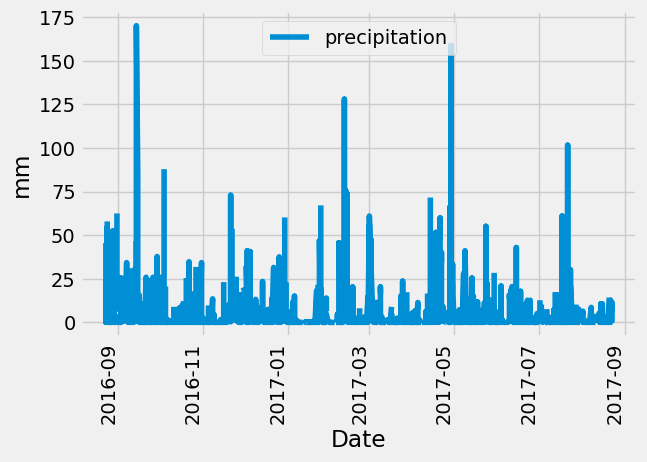

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
Recent_date = datetime.strptime(session.query(func.max(Measurement.date)).scalar(), '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
Start_date = Recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date,Measurement.prcp)\
        .filter(Measurement.date >= Start_date)\
        .order_by(Measurement.date.desc())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results = query.all() 
results_df = pd.DataFrame(results,columns=['date','precipitation'])

# Sort the dataframe by date
results_df['date'] = pd.to_datetime(results_df['date'])
results_df = results_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
results_df.plot(x='date',y='precipitation',grid=True,rot=90)
plt.legend(loc='upper center')
plt.xlabel('Date')
plt.ylabel('mm')

plt.show()


In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(results_df['precipitation'].describe())

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [29]:
stations_result = session.query(Measurement.station).distinct().all()
stations_result

[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_active = session.query(Measurement.station, func.count(Measurement.station))\
                              .group_by(Measurement.station)\
                              .order_by(func.count(Measurement.station).desc())
                        
station_count = station_active.all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station)\
                              .group_by(Measurement.station)\
                              .order_by(func.count(Measurement.station).desc()).first()
most_active_id = most_active[0]
cal_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                            .filter(Measurement.station == most_active_id)
cal_temp.all()

[(12.2, 29.4, 22.035822510822513)]

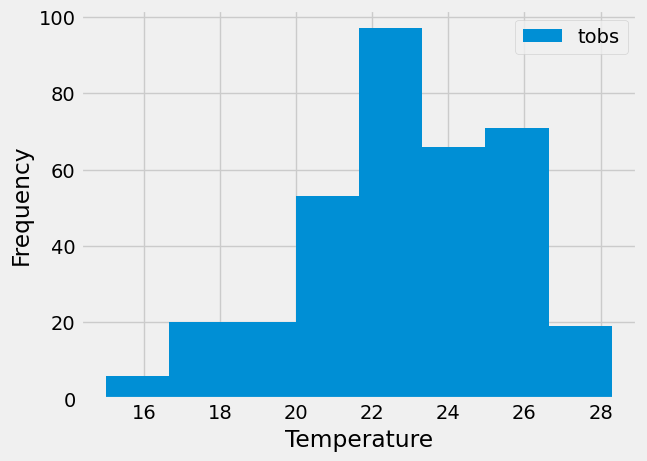

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12months = session.query(Measurement.date,Measurement.tobs)\
                            .filter(Measurement.station == most_active_id)\
                            .filter(Measurement.date >= Start_date).all()
last_df = pd.DataFrame(last_12months, columns = ['date','temperature'])
plt.hist(last_df['temperature'],bins=8)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.grid(True)
plt.show()

# Close Session

In [38]:
# Close Session
session.close()
